# Zurich Land Cover Classification

This script presents a visualization of training a U-Net classifier on 7 out of 8 available land cover classes of the Zurich dataset, and detecting the unseen class using a Density Forest.

## Import Libraries

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
%matplotlib inline
# python libraries
from multiprocessing import cpu_count
from sklearn.manifold import TSNE
import sys
import pandas as pd

from sklearn import decomposition, svm, preprocessing
from sklearn.utils import class_weight
from sklearn.mixture import GaussianMixture
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics.pairwise import polynomial_kernel
from keras.utils import to_categorical
from keras.models import load_model

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# custom libraries
base_dir = '/Users/cyrilwendl/Documents/EPFL'
#base_dir = '/raid/home/cwendl'  # for guanabana
sys.path.append(base_dir + '/SIE-Master/Code')  # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master')  # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code/density_tree')  # Path to density Tree package
from helpers.helpers import *
from helpers.data_augment import *
from helpers.data_loader import ZurichLoader
from helpers.cv_scorers import *
from helpers.cross_validator import ParameterSearch
from baselines.helpers import predict_with_dropout_imgs
from density_forest.density_forest import *
from density_forest.plots import *
from density_forest.helpers import *
from keras_helpers.unet import *
from keras_helpers.callbacks import *

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17316101858000610260
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10921197568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9569440364897416203
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [3]:
class_to_remove = 3

# Load Data

In [4]:
path = os.getcwd()

# data without overlap
data_train = ZurichLoader(path, 'train')
data_val = ZurichLoader(path, 'val')
data_test = ZurichLoader(path, 'test')

# data with overlap, for prediction
data_train_overlap = ZurichLoader(path, 'train', stride=32)
data_val_overlap = ZurichLoader(path, 'val', stride=32)
data_test_overlap = ZurichLoader(path, 'test', stride=32)

# class names and colors
names = data_train.names
colors = data_train.colors
n_classes = 9
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])
names_keep = np.asarray(names)[classes_to_keep]
print("classes to keep: " + str(names_keep))

classes to keep: ['Roads' 'Buildings' 'Grass' 'Bare Soil' 'Water' 'Railways'
 'Swimming Pools']


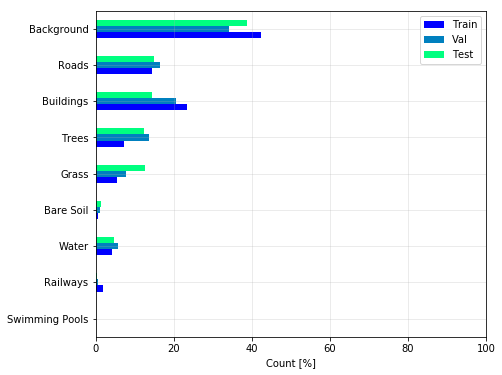

In [5]:
pred_labels_tr, cnt_tr = np.unique(data_train.gt_patches, return_counts=True)
pred_labels_val, cnt_val = np.unique(data_val.gt_patches, return_counts=True)
pred_labels_te, cnt_te = np.unique(data_test.gt_patches, return_counts=True)

cnt_tr = cnt_tr / np.sum(cnt_tr) * 100
cnt_val = np.concatenate((cnt_val / np.sum(cnt_val) * 100,[0]))
cnt_te = cnt_te / np.sum(cnt_te) * 100

df = pd.DataFrame({'Train':cnt_tr, 'Val':cnt_val, 'Test':cnt_te}, index=names[pred_labels_tr])

df[::-1].plot.barh(figsize=(7,6), colormap='winter')
plt.xlim([0,100])
plt.xlabel("Count [%]")
plt.grid(alpha=.3)
plt.savefig("../Figures/Zurich/Pred_count/ZH_dist.pdf", bbox_inches='tight', pad_inches=0)

# CNN Training

Data Split: 
- Training: 12 images
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

In [6]:
"""
# create copies of original data
y_train_label = y_train.copy()
y_val_label = y_val.copy()
y_test_label = y_test.copy()

# get class weights
labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())
class_weights[0] = 0  # give less weight to background label class
class_weights[5] = 7  # give less weight to bare soil class
class_weights[8] = 7  # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f" % (names[i], w))
"""

'\n# create copies of original data\ny_train_label = y_train.copy()\ny_val_label = y_val.copy()\ny_test_label = y_test.copy()\n\n# get class weights\nlabels_unique = np.unique(y_train.flatten())\nprint(labels_unique)\nclass_weights = class_weight.compute_class_weight(\'balanced\', labels_unique, y_train.flatten())\nclass_weights[0] = 0  # give less weight to background label class\nclass_weights[5] = 7  # give less weight to bare soil class\nclass_weights[8] = 7  # give less weight to swimming pool class\n\nprint("Class weights:")\nfor i, w in enumerate(class_weights):\n    print("%15s: %3.3f" % (names[i], w))\n'

In [7]:
"""

# convert to numpy arrays
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

# make y data categorical
y_train = to_categorical(y_train_label, n_classes)
y_val = to_categorical(y_val_label, n_classes)

y_train = y_train[..., classes_to_keep]
y_val = y_val[..., classes_to_keep]
n_classes = len(classes_to_keep)
class_weights = class_weights[classes_to_keep]

# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))
"""

'\n\n# convert to numpy arrays\nx_train = np.asarray(x_train)\nx_val = np.asarray(x_val)\nx_test = np.asarray(x_test)\n\n# make y data categorical\ny_train = to_categorical(y_train_label, n_classes)\ny_val = to_categorical(y_val_label, n_classes)\n\ny_train = y_train[..., classes_to_keep]\ny_val = y_val[..., classes_to_keep]\nn_classes = len(classes_to_keep)\nclass_weights = class_weights[classes_to_keep]\n\n# print shapes of variables\nfor var in x_train, y_train, x_val, y_val:\n    print(np.shape(var))\n'

### Train CNN

In [8]:
"""
# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improve
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto',
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
file_path = "weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./tensorboard', histogram_freq=0, write_graph=True, write_images=True)

# model setup
batch_size = 20
epochs = 300


def model_train(model, data_augmentation):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator(x_train, y_train,
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight=class_weights,  # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   # callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=cpu_count(),
                        use_multiprocessing=True)
                        
"""

'\n# callbacks (evaluated every epoch)\n# show loss and accuracy figures after each epoch\ncallback_plot = PlotLosses()\n\n# stop early if after several epochs the accuracy doesn\'t improve\ncallback_earlystop = EarlyStopping(monitor=\'val_loss\', min_delta=1e-4, patience=24, verbose=1, mode=\'auto\')\n\n# decrease learning rate when accuracy stops improving\ncallback_lr = ReduceLROnPlateau(monitor=\'val_loss\', factor=0.5, patience=12, verbose=1, mode=\'auto\',\n                                epsilon=1e-4, cooldown=0, min_lr=1e-8)\n\n# checkpoint to save weights at every epoch (in case of interruption)\nfile_path = "weights-improvement.hdf5"\ncallback_checkpoint = ModelCheckpoint(file_path, monitor=\'val_acc\', verbose=0, save_best_only=True, mode=\'max\')\n\ncallback_tensorboard = TensorBoard(log_dir=\'./tensorboard\', histogram_freq=0, write_graph=True, write_images=True)\n\n# model setup\nbatch_size = 20\nepochs = 300\n\n\ndef model_train(model, data_augmentation):\n    # Fit the 

In [9]:
# train or load model
# train the model
# model_unet = get_unet(n_classes, x_train.shape[1:])
# model_train(model_unet, data_augmentation=True)
# model_unet.save('models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '_2.h5')  # save model, weights

In [10]:
# load model
name_model = path + '/models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '.h5'    
model_unet = load_model(name_model, custom_objects={'fn': ignore_background_class_accuracy(0)})

### Prediction on Test Set

In [11]:
# get all predictions in training and test set
# training set
y_pred_tr = model_unet.predict(data_train_overlap.im_patches, verbose=1)
y_pred_tr = np.concatenate(remove_overlap(data_train.imgs, y_pred_tr, np.arange(10), 64, 32))
y_pred_label_tr = get_y_pred_labels(y_pred_tr, class_to_remove=class_to_remove, background=True)

# validation set
y_pred_val = model_unet.predict(data_val_overlap.im_patches, verbose=1)
y_pred_val = np.concatenate(remove_overlap(data_val.imgs, y_pred_val, np.arange(5), 64, 32))
y_pred_label_val = get_y_pred_labels(y_pred_val, class_to_remove=class_to_remove, background=True)

# test set
y_pred_te = model_unet.predict(data_test_overlap.im_patches, batch_size=20, verbose=1)
y_pred_te = np.concatenate(remove_overlap(data_test.imgs, y_pred_te, np.arange(5), 64, 32))
y_pred_label_te = get_y_pred_labels(y_pred_te, class_to_remove=class_to_remove, background=True)

# get indices of correctly / incorrectly predicted pixels
# train
pred_t_tr = (data_train.gt_patches != class_to_remove) & (data_train.gt_patches != 0)
pred_f_tr = data_train.gt_patches == class_to_remove

# val
pred_t_val = (data_val.gt_patches != class_to_remove) & (data_val.gt_patches != 0)
pred_f_val = data_val.gt_patches == class_to_remove

# test
pred_t_te = (data_test.gt_patches != class_to_remove) & (data_test.gt_patches != 0)
pred_f_te = data_test.gt_patches == class_to_remove

4786/4786 [==============================] - 3s 630us/step


### Accuracy Metrics (Test Set)

In [12]:
def OA(y_true, y_pred):
        """get overall accuracy"""
        return np.sum(y_true == y_pred)/len(y_true)

def AA(y_true, y_pred):
    """get average (macro) accuracy"""
    acc_cl = []
    for label in np.unique(y_pred):
        acc_cl.append(np.sum(y_true[y_pred==label] == y_pred[y_pred==label])/len(y_pred[y_pred==label]))
    return np.nanmean(acc_cl), acc_cl

In [13]:
# load model
name_model = path + '/models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '.h5'    
model_unet = load_model(name_model, custom_objects={'fn': ignore_background_class_accuracy(0)})

# Get OA, AA for train, val, test
# train
y_pred_tr_flattened = np.asarray(y_pred_label_tr.flatten()).astype('int')
y_tr_flattened = np.asarray(data_train.gt_patches.flatten()).astype('int')
filter_items = (y_tr_flattened != 0) & (y_tr_flattened != class_to_remove)
oa_tr = OA(y_tr_flattened[filter_items], y_pred_tr_flattened[filter_items])
aa_tr, aa_tr_cl = AA(y_tr_flattened[filter_items], y_pred_tr_flattened[filter_items])

# val
y_pred_val_flattened = np.asarray(y_pred_label_val.flatten()).astype('int')
y_val_flattened = np.asarray(data_val.gt_patches.flatten()).astype('int')
filter_items = (y_val_flattened != 0) & (y_val_flattened != class_to_remove)
oa_val = OA(y_val_flattened[filter_items], y_pred_val_flattened[filter_items])
aa_val, aa_val_cl = AA(y_val_flattened[filter_items], y_pred_val_flattened[filter_items])

# test
y_pred_te_flattened = np.asarray(y_pred_label_te.flatten()).astype('int')
y_te_flattened = np.asarray(data_test.gt_patches.flatten()).astype('int')
filter_items = (y_te_flattened != 0) & (y_te_flattened != class_to_remove)
oa_te = OA(y_te_flattened[filter_items], y_pred_te_flattened[filter_items])
aa_te, aa_te_cl = AA(y_te_flattened[filter_items], y_pred_te_flattened[filter_items])

print(np.round(np.multiply([oa_tr, aa_tr],100),2))
print(np.round(np.multiply([oa_val, aa_val],100),2))
print(np.round(np.multiply([oa_te, aa_te],100),2))

[65.36 58.84]
[88.79 72.59]
[88.58 71.4 ]


In [14]:
# Accuracy metrics
y_pred_flattened = np.asarray(y_pred_label_te.flatten()).astype('int')
y_test_flattened = np.asarray(data_test.gt_patches.flatten()).astype('int')

# mask background and removed classes for evaluation metrics
filter_items = (y_test_flattened != 0) & (y_test_flattened != class_to_remove)

# Class accuracy, average accuracy
print(metrics.classification_report(
    y_test_flattened[filter_items],
    y_pred_flattened[filter_items],
    target_names=names_keep,
    digits=3))


# Overall accuracy
OA = metrics.accuracy_score(y_test_flattened[filter_items], y_pred_flattened[filter_items])
print("Overall accuracy: %.3f %%" % (OA*100))

                precision    recall  f1-score   support

         Roads      0.852     0.888     0.869    726236
     Buildings      0.885     0.917     0.901    698275
         Grass      0.977     0.882     0.927    616207
     Bare Soil      0.581     0.740     0.651     67038
         Water      0.982     0.948     0.965    234163
      Railways      0.007     0.009     0.008     18526
Swimming Pools      0.000     0.000     0.000     10386

   avg / total      0.889     0.886     0.886   2370831

Overall accuracy: 88.583 %


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Distribution of predictions in unseen class

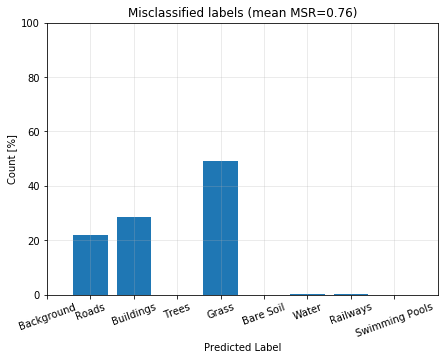

In [15]:
# distribution of predicted label
pred_labels, pred_counts = np.unique(y_pred_label_te[pred_f_te], return_counts=True)
pred_counts = pred_counts  / sum(pred_counts) * 100

# visualization
plt.figure(figsize=(7, 5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0, 10))
plt.ylim([0,100])
plt.xlabel("Predicted Label")
plt.ylabel("Count [%]")
plt.grid(alpha=.3)
plt.title("Misclassified labels (mean MSR=%.2f)" % np.mean(get_acc_net_msr(y_pred_te[pred_f_te])))
plt.xticks(pred_labels_te, names, rotation=20)
plt.savefig("../Figures/Zurich/Pred_count/ZH_pred-count_wo_cl" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()

# Novelty Detection

## Network

In [16]:
# precision-recall curves

# msr
y_scores = (-get_acc_net_msr(y_pred_te)).flatten()
y_true = pred_f_te.flatten()
precision_msr, recall_msr, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_msr = metrics.average_precision_score(y_true, y_scores)
auroc_msr = metrics.roc_auc_score(y_true, y_scores)
fpr_msr, tpr_msr, _ = metrics.roc_curve(y_true, y_scores)

# margin
y_scores = (-get_acc_net_max_margin(y_pred_te)).flatten()
precision_margin, recall_margin, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_margin = metrics.average_precision_score(y_true, y_scores)
auroc_margin = metrics.roc_auc_score(y_true, y_scores)
fpr_margin, tpr_margin, _ = metrics.roc_curve(y_true, y_scores)

# entropy
y_scores = (-get_acc_net_entropy(y_pred_te)).flatten()
precision_entropy, recall_entropy, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_entropy = metrics.average_precision_score(y_true, y_scores)
auroc_entropy = metrics.roc_auc_score(y_true, y_scores)
fpr_entropy, tpr_entropy, _ = metrics.roc_curve(y_true, y_scores)

In [17]:
# visualization
# MSR
probas_patches_msr = np.reshape((get_acc_net_msr(y_pred_te)).flatten(), np.shape(data_test.gt_patches))
probas_patches_msr -= np.min(probas_patches_msr)
probas_patches_msr /= np.max(probas_patches_msr)

# margin
probas_patches_margin = np.reshape((1 - get_acc_net_max_margin(y_pred_te)).flatten(), np.shape(data_test.gt_patches))
probas_patches_margin -= np.min(probas_patches_margin)
probas_patches_margin /= np.max(probas_patches_margin)

# entropy
probas_patches_entropy = np.reshape((1 - get_acc_net_entropy(y_pred_te)).flatten(), np.shape(data_test.gt_patches))
probas_patches_entropy -= np.min(probas_patches_entropy)
probas_patches_entropy /= np.max(probas_patches_entropy)

# show images
for img_idx in range(len(data_test.imgs)):
    acc_im_msr = convert_patches_to_image(data_test.imgs, probas_patches_msr[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_msr = imgs_stretch_eq([acc_im_msr])[0]
    plt.figure(figsize=(8, 8))
    plt.imshow(acc_im_msr[..., 0], cmap='RdYlGn')
    plt.savefig("../Figures/Zurich/Im_cert/cl_" + str(class_to_remove) + "/net_msr_im_" + str(img_idx) + ".pdf", 
                    bbox_inches='tight', pad_inches=0)
    plt.close()
    
    acc_im_margin = convert_patches_to_image(data_test.imgs, probas_patches_margin[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_margin = imgs_stretch_eq([acc_im_margin])[0]
    plt.figure(figsize=(8, 8))
    plt.imshow(acc_im_margin[..., 0], cmap='RdYlGn')
    plt.savefig("../Figures/Zurich/Im_cert/cl_" + str(class_to_remove) + "/net_margin_im_" + str(img_idx) + ".pdf", 
                    bbox_inches='tight', pad_inches=0)
    plt.close()
    
    acc_im_entropy = convert_patches_to_image(data_test.imgs, probas_patches_entropy[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_entropy = imgs_stretch_eq([acc_im_entropy])[0]
    plt.figure(figsize=(8, 8))
    plt.imshow(acc_im_entropy[..., 0], cmap='RdYlGn')
    plt.savefig("../Figures/Zurich/Im_cert/cl_" + str(class_to_remove) + "/net_entropy_im_" + str(img_idx) + ".pdf", 
                    bbox_inches='tight', pad_inches=0)
    plt.close()

## Dropout

In [18]:
# get predictions
y_preds = predict_with_dropout_imgs(model_unet, data_test_overlap.im_patches,
                                    data_test.imgs, np.arange(len(data_test_overlap.imgs)), batch_size=500,
                                    n_iter=20)

100%|██████████| 20/20 [01:10<00:00,  3.53s/it]


In [19]:
# get prediction and confidence
prediction = np.mean(y_preds, 0)
probas_dropout = -get_acc_net_entropy(prediction)

In [20]:
# dropout metrics
y_scores = probas_dropout.flatten()
precision_dropout, recall_dropout, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_dropout = metrics.average_precision_score(y_true, y_scores)
auroc_dropout = metrics.roc_auc_score(y_true, y_scores)
fpr_dropout, tpr_dropout, _ = metrics.roc_curve(y_true, y_scores)
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_dropout, pr_auc_dropout))

AUROC: 0.74, PR AUC: 0.24


In [21]:
# visualization
probas_patches_dropout = np.reshape(probas_dropout, np.shape(data_test.gt_patches))
probas_patches_dropout -= np.min(probas_patches_dropout)
probas_patches_dropout /= np.max(probas_patches_dropout)

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(len(data_test.imgs)):
    acc_im_dropout = convert_patches_to_image(data_test.imgs, -probas_patches_dropout[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_dropout = imgs_stretch_eq([acc_im_dropout])[0]
    plt.figure(figsize=(8, 8))
    plt.imshow(acc_im_dropout[..., 0], cmap='RdYlGn')
    plt.savefig("../Figures/Zurich/Im_cert/cl_" + str(class_to_remove) + "/dropout_im_" + str(img_idx) + ".pdf", 
                    bbox_inches='tight', pad_inches=0)
    plt.close()

## Retrieve Activations, PCA, t-SNE

In [22]:
# get activations for training Density Forest
act_train_all = get_activations_batch(model_unet, -2, data_train_overlap.im_patches, 20, verbose=True)

# retain only activation weights for which there is a ground truth
act_train_all = np.concatenate(remove_overlap(data_train.imgs, act_train_all, np.arange(len(data_train.imgs)), patch_size=64, stride=32))
act_train = act_train_all[pred_t_tr]

100%|██████████| 726/726 [00:19<00:00, 37.91it/s]


In [23]:
# get activations
act_val_all = get_activations_batch(model_unet, -2, data_val_overlap.im_patches, 20, verbose=True)

# retain only activation weights for which there is a ground truth
act_val_all = np.concatenate(remove_overlap(data_val.imgs, act_val_all, np.arange(len(data_val.imgs)),
                                            patch_size=64, stride=32))
act_val = act_val_all[pred_t_val]

100%|██████████| 235/235 [00:05<00:00, 42.54it/s]


In [24]:
# get activations for testing Density Forest
act_test = get_activations_batch(model_unet, -2, data_test_overlap.im_patches, 20, verbose=True)

# remove test activations overlap
act_test = remove_overlap(data_test.imgs, act_test, np.arange(len(data_test.imgs)), patch_size=64, stride=32)
act_test = np.concatenate(np.concatenate(np.concatenate(act_test)))

100%|██████████| 240/240 [00:03<00:00, 72.20it/s]


In [25]:
# get balanced data subset to show in figure
tsne_pts_per_class = 200
dataset_subset_indices = get_balanced_subset_indices(data_test.gt_patches.flatten(), 
                                                     np.arange(1, 9), pts_per_class=tsne_pts_per_class)
dataset_subset_indices = np.concatenate(dataset_subset_indices)

In [26]:
# t-SNE visualization
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500)
tsne_all = tsne.fit_transform(act_test[dataset_subset_indices])
tsne_y = data_test.gt_patches.flatten()[dataset_subset_indices]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.003s...
[t-SNE] Computed neighbors for 1600 samples in 0.144s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 1.616778
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.870083
[t-SNE] Error after 500 iterations: 0.519814


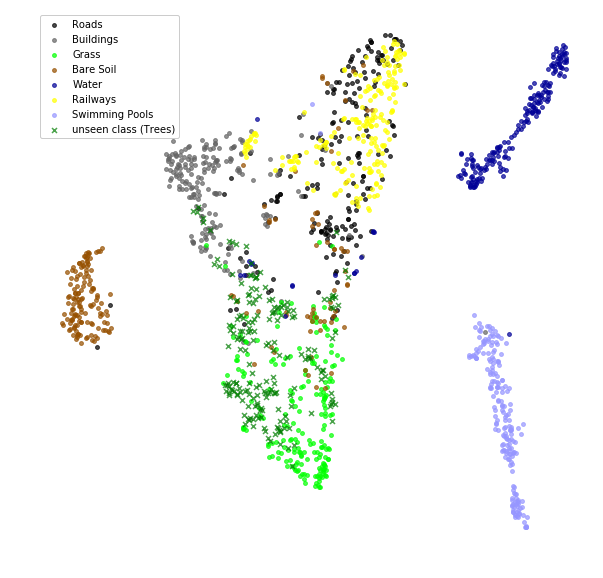

In [27]:
# plot
_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_axis_off()
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, names, colors, class_to_remove=class_to_remove)
plt.savefig("../Figures/Zurich/tSNE/t-SNE_" + str(names[class_to_remove]).lower() + "_before_PCA.pdf",
            bbox_inches='tight', pad_inches=0)

In [28]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=.95)
pca.fit(act_test)  # fit on training set without background pixels
n_components = np.alen(pca.explained_variance_ratio_)
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_)))

# transform training activations
act_train_all = pca.transform(np.concatenate(np.concatenate(act_train_all)))
act_train = pca.transform(act_train)

act_val_all = pca.transform(np.concatenate(np.concatenate(act_val_all)))
act_val = pca.transform(act_val)


# transform test set activations
act_test = pca.transform(act_test)

Variance explained by first 5 components: 0.97


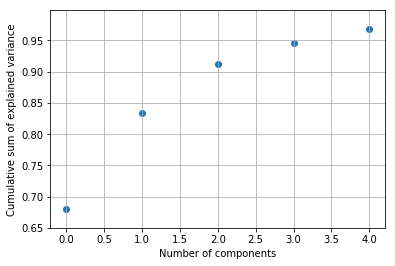

In [29]:
# TODO plot cumulative explained variance
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.savefig("../Figures/Zurich/PCA/pca_components_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.001s...
[t-SNE] Computed neighbors for 1600 samples in 0.061s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 1.422539
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.150120
[t-SNE] Error after 500 iterations: 0.493639


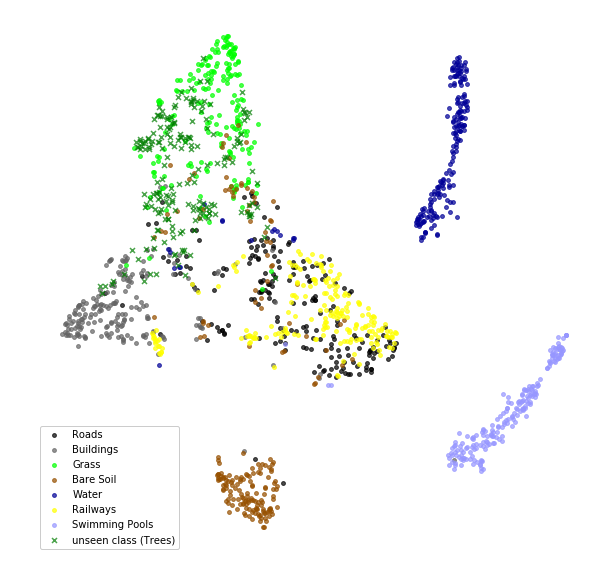

In [30]:
# t-SNE visualization after PCA
tsne_all = tsne.fit_transform(act_test[dataset_subset_indices])
# tsne without unseen class
tsne_train = tsne_all[tsne_y != class_to_remove]
# plot
_, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, names, colors, class_to_remove=class_to_remove)
ax.set_axis_off()
plt.savefig("../Figures/Zurich/tSNE/t-SNE_" + str(names[class_to_remove]).lower() + "_after_PCA.pdf",
            bbox_inches='tight', pad_inches=0)

Variance explained by first 3 components: 0.91


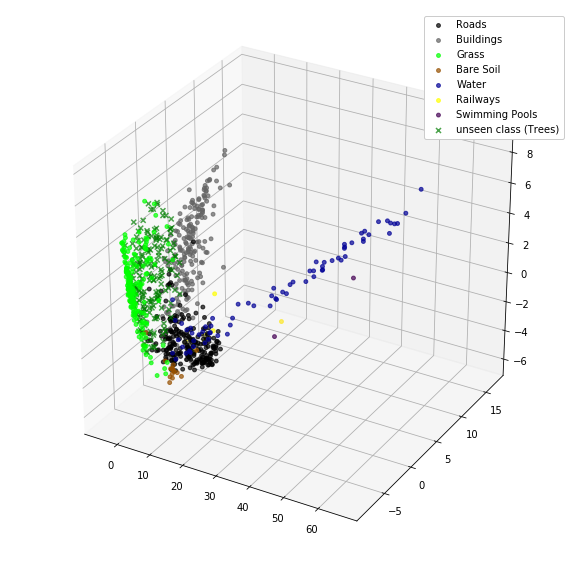

In [31]:
# plot first 3 PCA components
plot_pts_3d(act_test[:, :3], data_test.gt_patches.flatten(), classes_to_keep, names, colors,
            class_to_remove=class_to_remove, subsample_pct=.0003,
            s_name='../Figures/Zurich/PCA/pca_components_3d_' + str(names[class_to_remove]) + '.pdf')

print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

Variance explained by first 2 components: 0.83


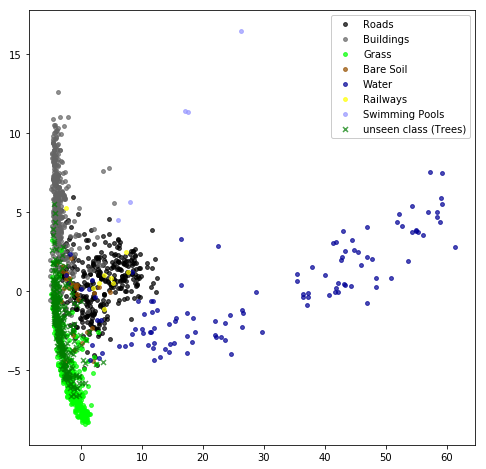

In [32]:
# plot first 2 PCA components
_, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_pts_2d(act_test[:, :2], data_test.gt_patches.flatten(), ax, classes_to_keep, names, colors,
            class_to_remove=class_to_remove, subsample_pct=.0005,
            s_name='../Figures/Zurich/PCA/pca_components_2d_' + str(names[class_to_remove]) + '.pdf')

print("Variance explained by first 2 components: %.2f" % np.sum(pca.explained_variance_ratio_[:2]))

## GMM

In [33]:
tuned_parameters = [{'n_components': np.arange(3, 12), 
                     'max_iter': [10000]}]

# do parameter search
ps_gmm = ParameterSearch(GaussianMixture, tuned_parameters, act_train, act_train_all,
                         pred_f_tr.flatten(), scorer_roc_probas_gmm, 
                         n_iter=3, verbosity=10, n_jobs=-1, subsample_train=.01, subsample_test=.001)
ps_gmm.fit()

Trying parameters: {'max_iter': 10000, 'n_components': 3}
Trying parameters: {'max_iter': 10000, 'n_components': 4}
Trying parameters: {'max_iter': 10000, 'n_components': 5}
Trying parameters: {'max_iter': 10000, 'n_components': 6}
Trying parameters: {'max_iter': 10000, 'n_components': 7}


[Parallel(n_jobs=40)]: Done   2 out of   9 | elapsed:   17.9s remaining:  1.0min


Trying parameters: {'max_iter': 10000, 'n_components': 8}
Trying parameters: {'max_iter': 10000, 'n_components': 9}


[Parallel(n_jobs=40)]: Done   3 out of   9 | elapsed:   22.2s remaining:   44.3s


Trying parameters: {'max_iter': 10000, 'n_components': 10}
Trying parameters: {'max_iter': 10000, 'n_components': 11}


[Parallel(n_jobs=40)]: Done   4 out of   9 | elapsed:   35.1s remaining:   43.9s
[Parallel(n_jobs=40)]: Done   5 out of   9 | elapsed:   47.7s remaining:   38.2s
[Parallel(n_jobs=40)]: Done   6 out of   9 | elapsed:   48.9s remaining:   24.4s
[Parallel(n_jobs=40)]: Done   7 out of   9 | elapsed:   50.9s remaining:   14.5s
[Parallel(n_jobs=40)]: Done   9 out of   9 | elapsed:   58.6s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   9 out of   9 | elapsed:   58.6s finished


In [34]:
ps_gmm.best_params

{'max_iter': 10000, 'n_components': 4}

In [35]:
# Fit GMM
gmm = GaussianMixture(**ps_gmm.best_params)
gmm.fit(draw_subsamples(act_train, .01))

# Predict
probas_gmm = gmm.predict_proba(act_test)
probas_gmm = get_acc_net_entropy(probas_gmm)

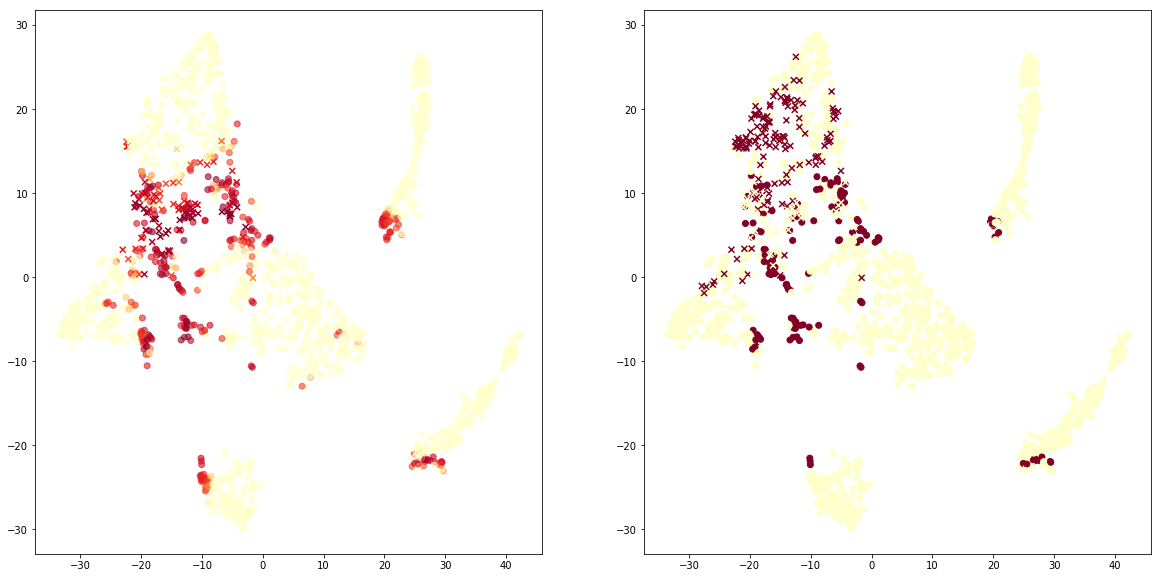

In [36]:
# plot
# dataset_subset_indicesices of correctly / wrongly predicted points
pred_f = pred_f_te.flatten()[dataset_subset_indices]
pred_t = pred_t_te.flatten()[dataset_subset_indices]

# plot colors
probas_gmm_c = imgs_stretch_eq([probas_gmm[..., np.newaxis]])[0, ..., 0]
colors_plt = plt.cm.YlOrRd(1 - probas_gmm_c)[:, :3][dataset_subset_indices]

# threshold for second plot
c_thresh_t = plt.cm.YlOrRd((probas_gmm_c[dataset_subset_indices] <
                            np.sort(probas_gmm_c[dataset_subset_indices])[200])*255)[:, :3]
c_thresh_f = plt.cm.YlOrRd((probas_gmm_c[dataset_subset_indices] > 
                            np.sort(probas_gmm_c[dataset_subset_indices])[200])*255)[:, :3]

# plot correctly predicted points (o marker)
_, axes = plt.subplots(1, 2, figsize=(20, 10)) 
axes[0].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=colors_plt[pred_t], alpha=.6)
axes[1].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=c_thresh_t[pred_t])

# plot incorrectly predicted points (x marker)
axes[0].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=colors_plt[pred_f], marker='x')
axes[1].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=c_thresh_f[pred_f], marker='x')
plt.show()

AUROC: 0.56, PR AUC: 0.17


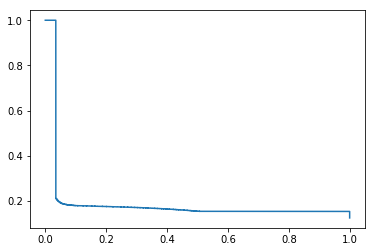

In [37]:
# precision-recall curve
y_scores = -probas_gmm
precision_gmm, recall_gmm, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_gmm = metrics.auc(recall_gmm, precision_gmm)
fpr_gmm, tpr_gmm, _ = metrics.roc_curve(y_true, y_scores)
auroc_gmm = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_gmm, precision_gmm)
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_gmm, pr_auc_gmm))

In [38]:
# visualization
probas_patches_gmm = np.reshape(probas_gmm, np.shape(data_test.gt_patches))
probas_patches_gmm -= np.min(probas_patches_gmm)
probas_patches_gmm /= np.max(probas_patches_gmm)

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(len(data_test.imgs)):
    acc_im_gmm = convert_patches_to_image(data_test.imgs, probas_patches_gmm[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_gmm = imgs_stretch_eq([acc_im_gmm])[0]
    plt.figure(figsize=(8, 8))
    plt.imshow(acc_im_gmm[..., 0], cmap='RdYlGn')
    plt.savefig("../Figures/Zurich/Im_cert/cl_" + str(class_to_remove) + "/GMM_im_" + str(img_idx) + ".pdf", 
                    bbox_inches='tight', pad_inches=0)
    plt.close()


# SVM

In [39]:
act_train_svm = preprocessing.scale(act_train)
act_val_all_svm = preprocessing.scale(act_val_all)
act_test_svm = preprocessing.scale(act_test)

In [40]:
tuned_parameters = [{'kernel': ['rbf'],
                     'nu': [1e-4, 1e-3, 1e-2, 1e-1, 5e-1]
                     },
                    {'kernel': ['poly'],
                     'degree': np.arange(1, 7),
                     'nu': [1e-4, 1e-3, 1e-2, 1e-1, 5e-1],
                     'max_iter': [10000]}]

# do parameter search
ps_svm = ParameterSearch(svm.OneClassSVM, tuned_parameters, act_train_svm, act_train_all,
                         pred_f_tr.flatten(), scorer_roc_probas_svm, n_iter=5,
                         verbosity=11, n_jobs=-1, subsample_train=.0001, subsample_test=.001)
ps_svm.fit()


Trying parameters: {'kernel': 'rbf', 'nu': 0.0001}
Trying parameters: {'kernel': 'rbf', 'nu': 0.001}
Trying parameters: {'kernel': 'rbf', 'nu': 0.01}
Trying parameters: {'kernel': 'rbf', 'nu': 0.1}


[Parallel(n_jobs=40)]: Done   1 tasks      | elapsed:   34.9s


Trying parameters: {'kernel': 'rbf', 'nu': 0.5}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}


[Parallel(n_jobs=40)]: Done   4 out of  35 | elapsed:   40.8s remaining:  5.3min


Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}


[Parallel(n_jobs=40)]: Done   8 out of  35 | elapsed:   48.4s remaining:  2.7min


Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


[Parallel(n_jobs=40)]: Done  12 out of  35 | elapsed:   56.0s remaining:  1.8min


Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}


[Parallel(n_jobs=40)]: Done  16 out of  35 | elapsed:  1.1min remaining:  1.2min


Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 4, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 4, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 4, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


[Parallel(n_jobs=40)]: Done  20 out of  35 | elapsed:  1.2min remaining:   53.6s


Trying parameters: {'degree': 4, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 4, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 5, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 5, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}


[Parallel(n_jobs=40)]: Done  24 out of  35 | elapsed:  1.3min remaining:   35.5s


Trying parameters: {'degree': 5, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 5, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Trying parameters: {'degree': 5, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 6, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 6, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}


[Parallel(n_jobs=40)]: Done  28 out of  35 | elapsed:  1.4min remaining:   21.7s


Trying parameters: {'degree': 6, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 6, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 6, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


[Parallel(n_jobs=40)]: Done  32 out of  35 | elapsed:  1.5min remaining:    8.6s
[Parallel(n_jobs=40)]: Done  35 out of  35 | elapsed:  1.6min finished


In [41]:
print(ps_svm.best_params)

{'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}


In [42]:
# Fit SVM
clf_svm = svm.OneClassSVM(**ps_svm.best_params)
clf_svm.fit(draw_subsamples(act_train_svm, .001))

OneClassSVM(cache_size=200, coef0=0.0, degree=1, gamma='auto', kernel='poly',
      max_iter=10000, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [43]:
# predict
probas_svm = clf_svm.decision_function(act_test_svm[dataset_subset_indices])
probas_svm -= np.min(probas_svm)
probas_svm /= np.max(probas_svm)

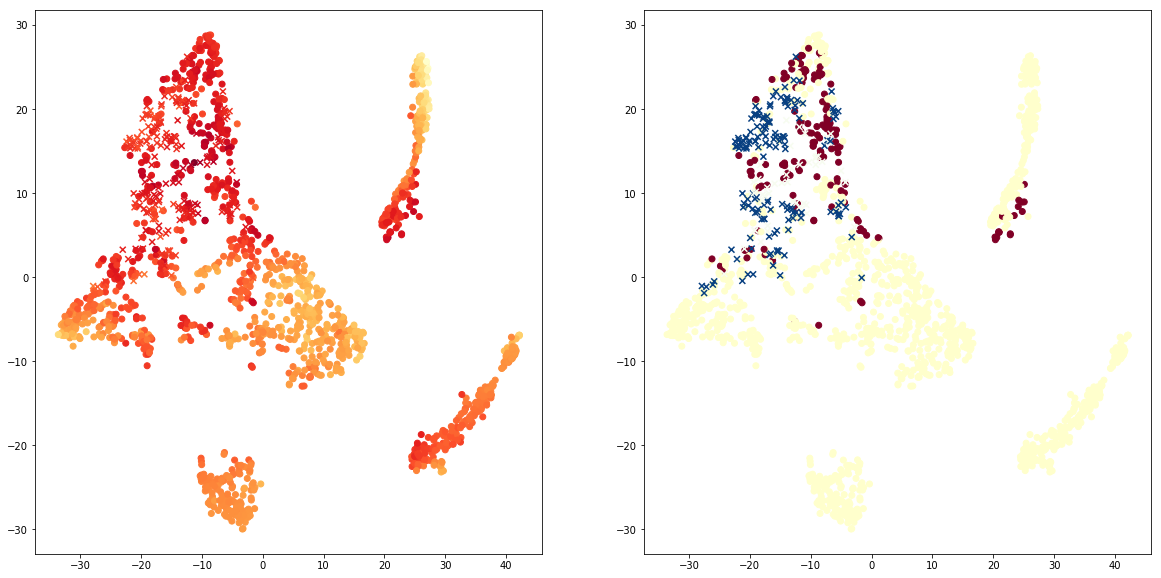

In [44]:
# plot
pred_f = pred_f_te.flatten()[dataset_subset_indices]
pred_t = pred_t_te.flatten()[dataset_subset_indices]

# plot colors
probas_svm_c = probas_svm[..., 0]
colors_plt = plt.cm.YlOrRd(1 - probas_svm_c)[..., :3]

# threshold for second plot
c_thresh_t = plt.cm.YlOrRd((probas_svm_c < np.sort(probas_svm_c)[200])*255)[:, :3]

c_thresh_f = plt.cm.GnBu((probas_svm_c > np.sort(probas_svm_c)[200])*255)[:, :3]

# plot correctly predicted points (o marker)
_, axes = plt.subplots(1, 2, figsize=(20, 10)) 
axes[0].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=colors_plt[pred_t])
axes[1].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=c_thresh_t[pred_t])

# plot incorrectly predicted points (x marker)
axes[0].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=colors_plt[pred_f], marker='x')
axes[1].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=c_thresh_f[pred_f], marker='x')
plt.show()

In [45]:
probas_svm = clf_svm.decision_function(act_test_svm)
probas_svm -= np.min(probas_svm)
probas_svm /= np.max(probas_svm)

In [46]:
# precision-recall curve
y_scores = -probas_svm
# PR
precision_svm, recall_svm, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_svm = metrics.auc(recall_svm, precision_svm)

# ROC
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_true, y_scores)
auroc_svm = metrics.roc_auc_score(y_true, y_scores)

In [47]:
auroc_svm, pr_auc_svm

(0.690730198508674, 0.17257013725783282)

In [48]:
# visualization
probas_patches_svm = np.reshape(probas_svm, np.shape(data_test.gt_patches))
probas_patches_svm -= np.min(probas_patches_svm)
probas_patches_svm /= np.max(probas_patches_svm)

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(len(data_test.imgs)):
    acc_im_svm = convert_patches_to_image(data_test.imgs, probas_patches_svm[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_svm = imgs_stretch_eq([acc_im_svm])[0]
    plt.figure(figsize=(8, 8))
    plt.imshow(acc_im_svm[..., 0], cmap='RdYlGn')
    plt.savefig("../Figures/Zurich/Im_cert/cl_" + str(class_to_remove) + "/svm_im_" + str(img_idx) + ".pdf", 
                    bbox_inches='tight', pad_inches=0)
    plt.close()

#### Visualize Kernels

In [49]:
#subsample, ind_sub = draw_subsamples(act_train_svm,.0003, return_indices=True)
#[ind_sub]
#subsample = subsample[np.argsort(gts)]

In [50]:
gts_train = data_train.gt_patches[(data_train.gt_patches!=class_to_remove) & (data_train.gt_patches!=0)]

In [51]:
subset_ind = get_balanced_subset_indices(gts_train, classes_to_keep, pts_per_class=50)

In [52]:
subsample = act_train_svm[np.concatenate(subset_ind)]

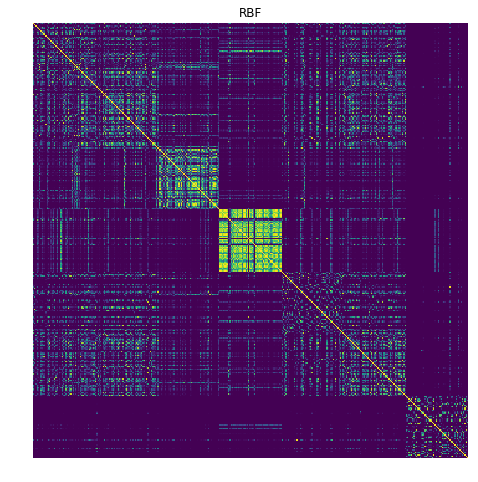

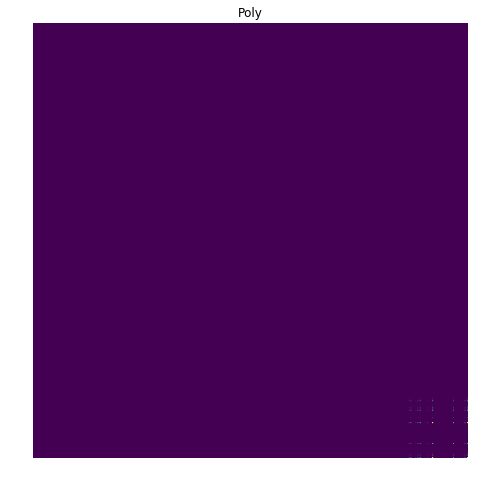

In [53]:
# RBF
K = RBF()
K_X = K.__call__(subsample)
plt.figure(figsize=(8,8))
plt.imshow(K_X)
plt.axis('off')
plt.savefig("../Figures/Zurich/Kernels/Kernel_RBF_wo_cl_" + str(class_to_remove) + ".pdf", 
                    bbox_inches='tight', pad_inches=0)
plt.title('RBF')

# polynomial
deg = 10
K_X = polynomial_kernel(subsample, degree=deg)

plt.figure(figsize=(8,8))
plt.imshow(K_X)
plt.axis('off')
plt.savefig("../Figures/Zurich/Kernels/Kernel_poly_wo_cl_" + str(class_to_remove) + "_deg_" + str(deg) + ".pdf", 
                    bbox_inches='tight', pad_inches=0)
plt.title('Poly')
plt.show()

## Density Forest

In [54]:
# Create DensityForest instance
clf_df = DensityForest(max_depth=2, min_subset=.1, n_trees=100,
                       subsample_pct=.1, n_jobs=-1, verbose=10,
                       ig_improvement=.4)

In [55]:
# fit to training data
clf_df.fit(tsne_train)

Number of points on which to train each tree: 140
Minimum number of points in each leaf: 14


[Parallel(n_jobs=40)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=40)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=40)]: Done  32 out of 100 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=40)]: Done  43 out of 100 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=40)]: Done  54 out of 100 | elapsed:    0.7s remaining:    0.6s
[Parallel(n_jobs=40)]: Done  65 out of 100 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=40)]: Done  76 out of 100 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=40)]: Done  87 out of 100 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=40)]: Done  98 out of 100 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    1.0s finished


Number of created root nodes: 100
Mean number of clusters created per tree: 4


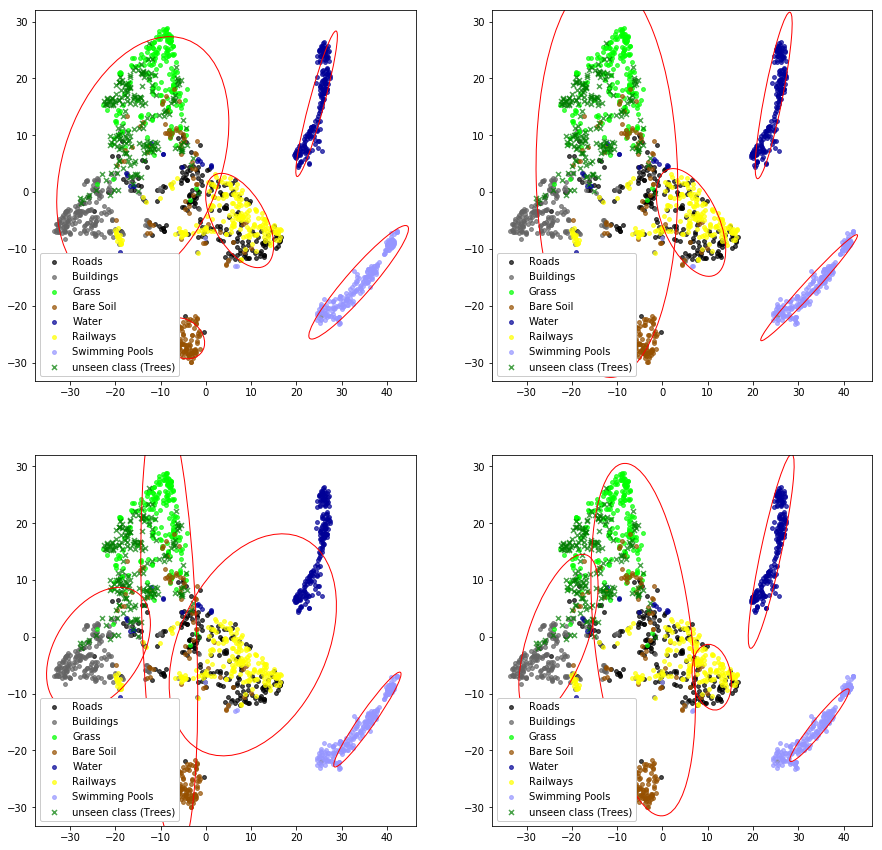

In [56]:
# Show ellipses on plot
_, axes = plt.subplots(2, 2, figsize=(15, 15)) 
for i in range(4):
    plot_pts_2d(tsne_all, tsne_y, axes[int(i/2)][np.mod(i, 2)], classes_to_keep, names, 
                colors, class_to_remove=class_to_remove)
    covs, means = get_clusters(clf_df.root_nodes[i], [], [])
    plot_ellipses(axes[int(i / 2)][np.mod(i, 2)], means, covs)

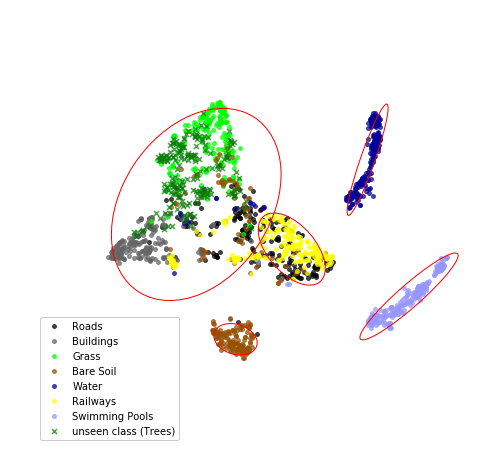

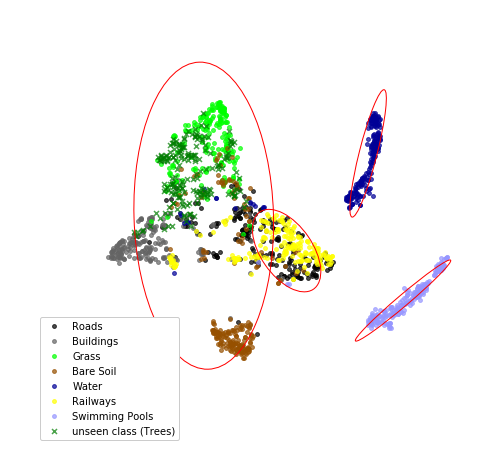

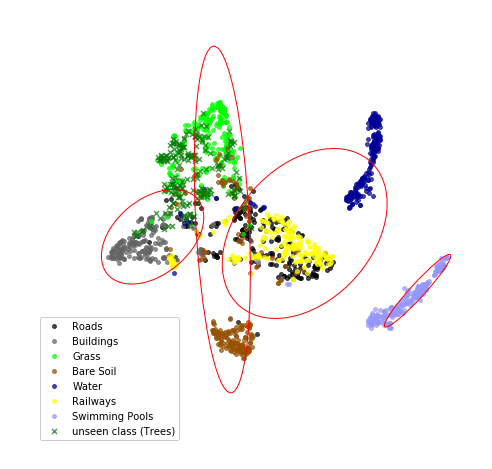

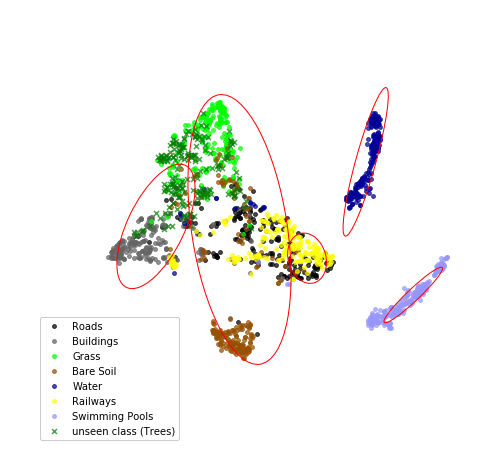

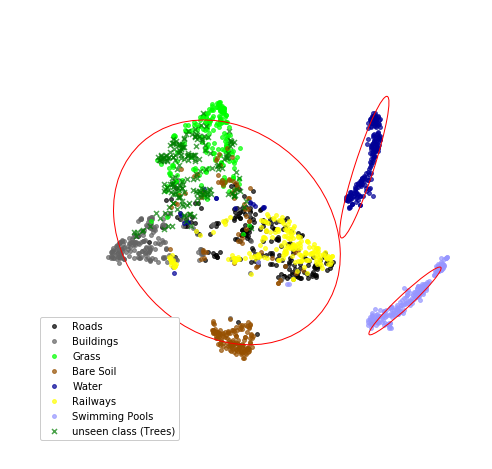

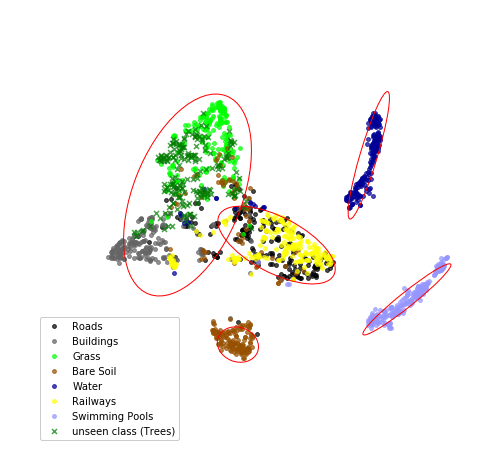

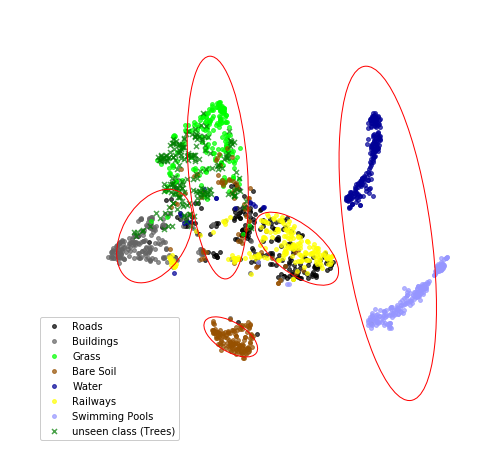

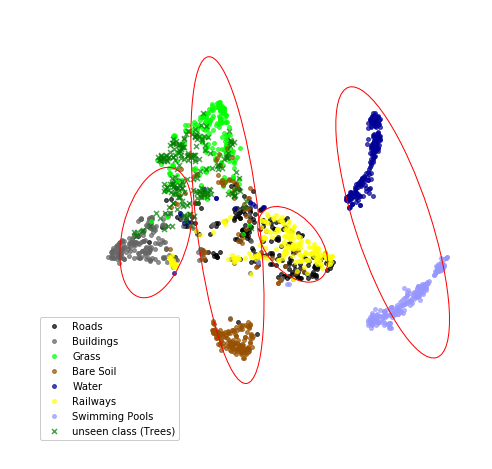

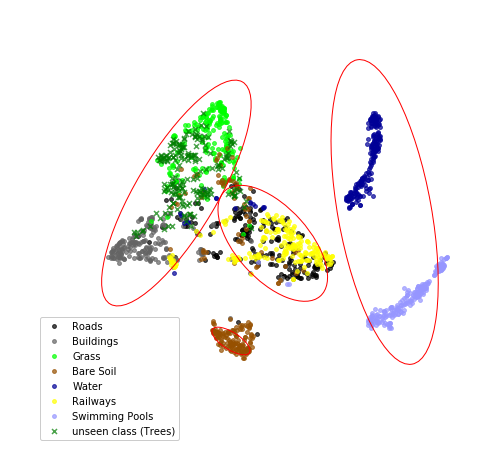

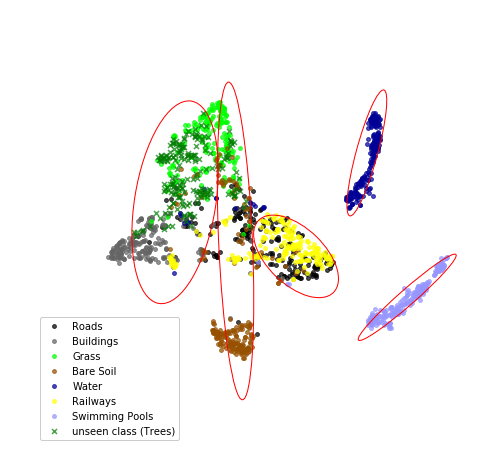

In [57]:
# export some ellipses for GIF

for i in range(10):
    _, ax = plt.subplots(1, 1, figsize=(8, 8)) 
    plt.xlim([-50, 50])
    plt.ylim([-50, 50])
    plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, names, colors, 
                class_to_remove=class_to_remove)
    covs, means = get_clusters(clf_df.root_nodes[i], [], [])
    plot_ellipses(ax, means, covs)
    plt.axis('off')
    plt.savefig("../Figures/Zurich/GIF/TSNE_act_wo_cl" + str(class_to_remove) + "_"+str(i)+".pdf", 
                bbox_inches='tight', pad_inches=0)

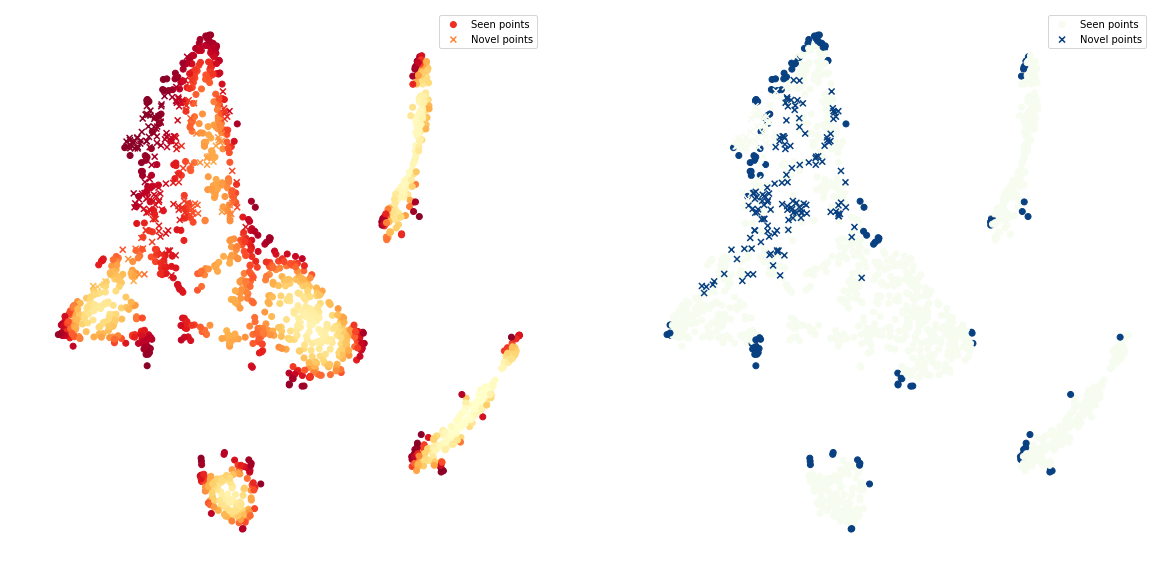

In [58]:
# plot

# get probabilities for all images
probas_df = np.log(clf_df.predict(tsne_all))

# indices of correctly / wrongly predicted points
pred_f = pred_f_te.flatten()[dataset_subset_indices]
pred_t = pred_t_te.flatten()[dataset_subset_indices]

# plot colors
probas_df_c = imgs_stretch_eq(probas_df[np.newaxis, ..., np.newaxis])[0, ..., 0]
colors_plt = plt.cm.YlOrRd(1 - probas_df_c)[..., :3]

# threshold for second plot
c_thresh_t = plt.cm.GnBu((probas_df < np.sort(probas_df)[tsne_pts_per_class])*255)[:, :3]

c_thresh_f = plt.cm.GnBu((probas_df > np.sort(probas_df)[tsne_pts_per_class])*255)[:, :3]

# plot correctly predicted points (o marker)
fig, axes = plt.subplots(1, 2, figsize=(20, 10)) 
axes[0].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=colors_plt[pred_t])
axes[1].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=c_thresh_t[pred_t])

# plot incorrectly predicted points (x marker)
axes[0].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=colors_plt[pred_f], marker='x')
axes[1].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=c_thresh_f[pred_f], marker='x')
[axes[i].legend(['Seen points', 'Novel points']) for i in range(2)]
[axes[i].set_axis_off() for i in range(2)]
extent = axes[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig("../Figures/Zurich/GIF/probas.pdf", bbox_inches=extent, pad_inches=0)
plt.show()

### Fit on real data

In [59]:
default_params = {'n_trees': 30, 'n_max_dim': 1, 'n_jobs': -1, 
                  'verbose': 0, 'subsample_pct': .0002, 'min_subset': 1e-3}

tuned_params = [{'max_depth': [1, 2, 3],
                 'ig_improvement': [-np.infty, 0, .4, .7]
}]
                 

# do parameter search
ps_df = ParameterSearch(DensityForest, tuned_params, act_train, act_train_all,
                        pred_f_tr.flatten(), scorer_roc_probas_df,
                        n_iter=3, verbosity=11, n_jobs=1, subsample_train=1, 
                        subsample_test=.001, default_params=default_params)

print("Testing %i combinations %i times" % (len(ps_df.combinations), ps_df.n_iter))
print(ps_df.combinations)
ps_df.fit()

Testing 12 combinations 3 times
[{'ig_improvement': -inf, 'max_depth': 1}
 {'ig_improvement': -inf, 'max_depth': 2}
 {'ig_improvement': -inf, 'max_depth': 3}
 {'ig_improvement': 0, 'max_depth': 1}
 {'ig_improvement': 0, 'max_depth': 2}
 {'ig_improvement': 0, 'max_depth': 3}
 {'ig_improvement': 0.4, 'max_depth': 1}
 {'ig_improvement': 0.4, 'max_depth': 2}
 {'ig_improvement': 0.4, 'max_depth': 3}
 {'ig_improvement': 0.7, 'max_depth': 1}
 {'ig_improvement': 0.7, 'max_depth': 2}
 {'ig_improvement': 0.7, 'max_depth': 3}]
Trying parameters: {'ig_improvement': -inf, 'max_depth': 1, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.1s remaining:    0.0s


Trying parameters: {'ig_improvement': -inf, 'max_depth': 2, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


Trying parameters: {'ig_improvement': -inf, 'max_depth': 3, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.0min remaining:    0.0s


Trying parameters: {'ig_improvement': 0, 'max_depth': 1, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.9min remaining:    0.0s


Trying parameters: {'ig_improvement': 0, 'max_depth': 2, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min remaining:    0.0s


Trying parameters: {'ig_improvement': 0, 'max_depth': 3, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.0min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.4, 'max_depth': 1, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  6.9min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.4, 'max_depth': 2, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  7.9min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.4, 'max_depth': 3, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  9.0min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.7, 'max_depth': 1, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  9.9min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.7, 'max_depth': 2, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.0002, 'verbose': 0}
Trying parameters: {'ig_improvement': 0.7, 'max_depth': 3, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 12.0min finished


In [60]:
ps_df.best_params

{'ig_improvement': 0.4, 'max_depth': 3}

In [61]:
# Create DensityForest instance
default_params['verbose'] = 1
default_params['batch_size'] = 10000

clf_df = DensityForest(**ps_df.best_params, **default_params)

In [62]:
clf_df.fit(act_train)

Number of points on which to train each tree: 1489
Minimum number of points in each leaf: 1


[Parallel(n_jobs=40)]: Done  13 out of  30 | elapsed:    6.4s remaining:    8.4s
[Parallel(n_jobs=40)]: Done  30 out of  30 | elapsed:    8.0s finished


Number of created root nodes: 30
Mean number of clusters created per tree: 15


In [63]:
# get probabilities for all images
probas_df = clf_df.predict(act_test)

Total steps: 485
Number of jobs: 40 


[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   34.7s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:  1.6min
[Parallel(n_jobs=40)]: Done 484 out of 484 | elapsed:  2.0min finished


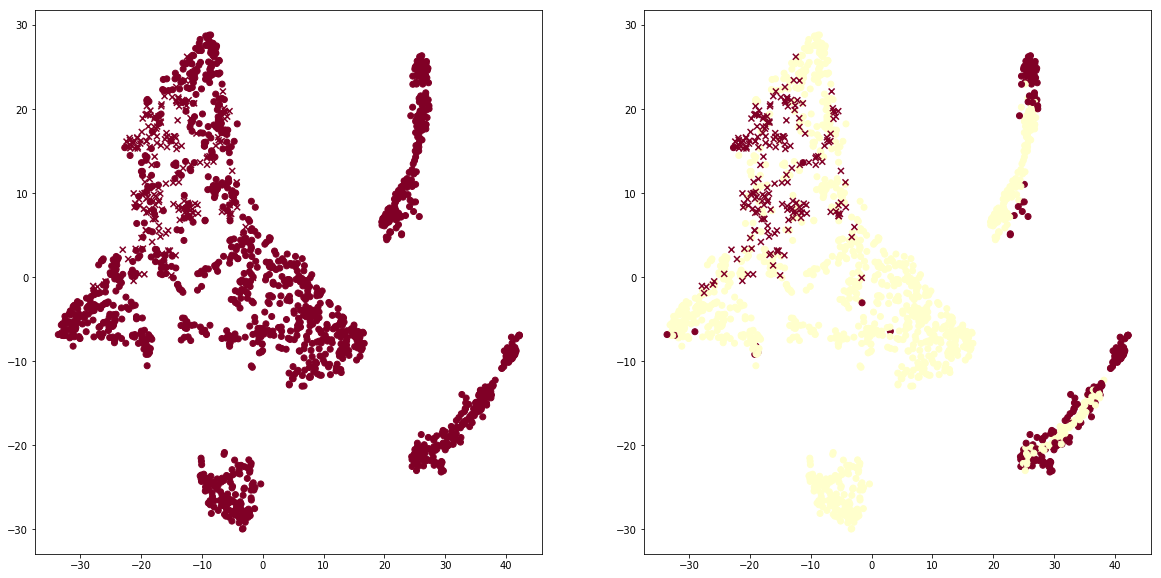

In [64]:
# plot
# indices of correctly / wrongly predicted points
pred_f = pred_f_te.flatten()[dataset_subset_indices]
pred_t = pred_t_te.flatten()[dataset_subset_indices]

# plot colors
#probas_df_c = imgs_stretch_eq(probas_df[dataset_subset_indices, np.newaxis])[0, ..., 0]
probas_df_c = probas_df[dataset_subset_indices]
colors_plt = plt.cm.YlOrRd(1-np.log(probas_df_c))[..., :3]

# threshold for second plot
c_thresh_t = plt.cm.YlOrRd((probas_df_c < np.sort(probas_df_c)[200])*255)[:, :3]
c_thresh_f = plt.cm.YlOrRd((probas_df_c > np.sort(probas_df_c)[200])*255)[:, :3]

# plot correctly predicted points (o marker)
_, axes = plt.subplots(1, 2, figsize=(20, 10)) 
axes[0].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=colors_plt[pred_t])
axes[1].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=c_thresh_t[pred_t])

# plot incorrectly predicted points (x marker)
axes[0].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=colors_plt[pred_f], marker='x')
axes[1].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=c_thresh_f[pred_f], marker='x')
# axes[0].savefig("../Figures/Zurich/GIF/probas.pdf", bbox_inches='tight', pad_inches=0)

### Post-Treatment

In [65]:
# reshape probas to (n_patches, patch_size, patch_size)
probas_patches_df = np.reshape(probas_df, np.shape(data_test.gt_patches))

# transformations
probas_patches_df -= np.nanmin(probas_patches_df)
probas_patches_df /= np.nanmax(probas_patches_df)

### Metrics

In [66]:
# metrics
y_scores = -probas_df

# PR
precision_df, recall_df, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_df = metrics.auc(recall_df, precision_df)

# ROC
fpr_df, tpr_df, _ = metrics.roc_curve(y_true, y_scores)
auroc_df = metrics.roc_auc_score(y_true, y_scores)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_df, pr_auc_df))

AUROC: 0.46, PR AUC: 0.10


In [67]:
# visualization
probas_patches_df = np.reshape(probas_df, np.shape(data_test.gt_patches))
probas_patches_df -= np.min(probas_patches_df)
probas_patches_df /= np.max(probas_patches_df)

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(4):
    acc_im_df = convert_patches_to_image(data_test.imgs, -probas_patches_df[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_df = imgs_stretch_eq([acc_im_df])[0]
    plt.figure(figsize=(8, 8))
    plt.imshow(acc_im_df[..., 0], cmap='RdYlGn')
    plt.savefig("../Figures/Zurich/Im_cert/cl_" + str(class_to_remove) + "/df_im_" + str(img_idx) + ".pdf", 
                    bbox_inches='tight', pad_inches=0)
    plt.close()

## Plot Results

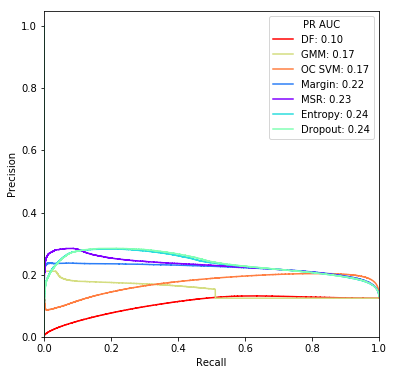

In [68]:
# Precision-Recall Curve
# order according to increasing score
scores_pr = [pr_auc_msr, pr_auc_margin, pr_auc_entropy, pr_auc_dropout, pr_auc_gmm, pr_auc_svm, pr_auc_df]

recalls = [recall_msr, recall_margin, recall_entropy, recall_dropout, recall_gmm, recall_svm, recall_df]
precisions = [precision_msr, precision_margin, precision_entropy, precision_dropout, 
              precision_gmm, precision_svm, precision_df]

names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'OC SVM', 'DF'])
scores_order = np.argsort(scores_pr)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_pr)))[:, :3]

# plot
plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.step(recalls[i], precisions[i], where='post', c=colors_lines[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_pr[i]) for i in scores_order], title="PR AUC")
plt.savefig("../Figures/Zurich/Metrics/PR_pred_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()

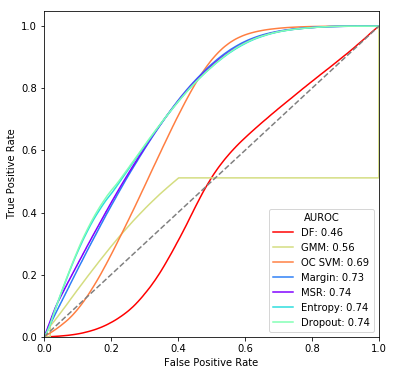

In [69]:
# ROC
# order according to increasing score
scores_auc = [auroc_msr, auroc_margin, auroc_entropy, auroc_dropout, auroc_gmm, auroc_svm, auroc_df]
fprs = [fpr_msr, fpr_margin, fpr_entropy, fpr_dropout, fpr_gmm, fpr_svm, fpr_df]
tprs = [tpr_msr, tpr_margin, tpr_entropy, tpr_dropout, tpr_gmm, tpr_svm, tpr_df]
scores_order = np.argsort(scores_auc)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_auc)))[:, :3]

# plot
plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.step(fprs[i], tprs[i], where='post', c=colors_lines[i])

plt.plot([0, 1], [0, 1], '--', c='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_auc[i]) for i in scores_order], title="AUROC")
plt.savefig("../Figures/Zurich/Metrics/ROC_pred_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()